In [1]:
!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train=pd.read_parquet("Cleaned_Data/train.parquet")
train = train[train['date']>='2017-01-01']
train.reset_index(drop=True, inplace=True)
pd.set_option('display.max_columns',21)

In [5]:
train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,lag_7,rolling_mean_7,rolling_mean_30,transactions,type,cluster,dcoilwtico,family,is_holiday,day,dayofweek,is_weekend,weekofyear,quarter
0,2017-01-01,25,99197,0.693147,0,2017,1,2.302585,1.236956,1.101259,7.0,3,1,53.75,12,1,1,6,1,52,1
1,2017-01-01,25,103665,2.079442,0,2017,1,2.079442,1.671888,1.106397,7.0,3,1,53.75,5,1,1,6,1,52,1
2,2017-01-01,25,105574,0.693147,0,2017,1,1.945910,1.957169,1.602076,7.0,3,1,53.75,12,1,1,6,1,52,1
3,2017-01-01,25,105857,1.609438,0,2017,1,1.609438,2.417515,1.421993,7.0,3,1,53.75,12,1,1,6,1,52,1
4,2017-01-01,25,106716,1.098612,0,2017,1,2.397895,1.326757,1.188288,7.0,3,1,53.75,12,1,1,6,1,52,1


In [7]:
train.shape

(23806628, 21)

In [9]:
test = pd.read_csv('Cleaned_data/test.csv')
test.head()

,date,store_nbr,item_nbr,onpromotion,year,month,is_weekend,transactions,type,cluster,dcoilwtico,family,is_holiday,day,dayofweek,weekofyear,quarter
0,2017-08-16,1,96995,0,2017,8,0,0.0,3,13,46.8,12,0,16,2,33,3
1,2017-08-16,1,99197,0,2017,8,0,0.0,3,13,46.8,12,0,16,2,33,3
2,2017-08-16,1,103501,0,2017,8,0,0.0,3,13,46.8,7,0,16,2,33,3
3,2017-08-16,1,103520,0,2017,8,0,0.0,3,13,46.8,12,0,16,2,33,3
4,2017-08-16,1,103665,0,2017,8,0,0.0,3,13,46.8,5,0,16,2,33,3


In [11]:
test.shape

(3370464, 17)

In [13]:
items=pd.read_csv("Cleaned_Data/items.csv")
train = train.merge(items[['item_nbr', 'perishable']], on='item_nbr', how='left')
train['perishable'] = train['perishable'].fillna(0)
test = test.merge(items[['item_nbr', 'perishable']], on='item_nbr', how='left')
test['perishable'] = test['perishable'].fillna(0)

In [29]:
test['lag_7'] = -1
test['rolling_mean_7'] = -1
test['rolling_mean_30'] = -1
test.head()

,date,store_nbr,item_nbr,onpromotion,year,month,is_weekend,transactions,type,cluster,dcoilwtico,family,is_holiday,day,dayofweek,weekofyear,quarter,perishable,lag_7,rolling_mean_7,rolling_mean_30
0,2017-08-16,1,96995,0,2017,8,0,0.0,3,13,46.8,12,0,16,2,33,3,0,-1,-1,-1
1,2017-08-16,1,99197,0,2017,8,0,0.0,3,13,46.8,12,0,16,2,33,3,0,-1,-1,-1
2,2017-08-16,1,103501,0,2017,8,0,0.0,3,13,46.8,7,0,16,2,33,3,0,-1,-1,-1
3,2017-08-16,1,103520,0,2017,8,0,0.0,3,13,46.8,12,0,16,2,33,3,0,-1,-1,-1
4,2017-08-16,1,103665,0,2017,8,0,0.0,3,13,46.8,5,0,16,2,33,3,1,-1,-1,-1


In [31]:
features = ['store_nbr','item_nbr','onpromotion','perishable','lag_7','rolling_mean_7','rolling_mean_30','transactions','dayofweek','type','cluster',
            'dcoilwtico','family','is_holiday']
X_train = train[features]
y_train = train['unit_sales']
X_test = test[features]

## Before Hyperparameter Tuning

In [17]:
#tscv = TimeSeriesSplit(n_splits=5)

#rmse_scores = []
#r2_scores = []

#params = {
 #   'objective': 'regression',
 #   'metric': 'rmse',
 #   'verbosity': -1,
 #   'boosting_type': 'gbdt',
 #   'learning_rate': 0.05,
 #   'num_leaves': 31,
 #   'max_depth': -1,
 #   'subsample': 0.8,
 #   'colsample_bytree': 0.8,
 #   'device': 'cpu',             
 #   'max_bin': 255,           
 #   'min_data_in_bin': 3,
 #   'feature_fraction': 0.8,
 #   'bagging_fraction': 0.8,
 #   'bagging_freq': 1,
 #   'force_col_wise': True        
#}

#for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
 #   X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
 #   y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] 
    
 #   model = LGBMRegressor(**params, n_estimators=500, random_state=42, n_jobs=-1)
    
    #  model.fit(
    #    X_tr, 
    #    y_tr,
    #    eval_set=[(X_val, y_val)],
    #    eval_metric='rmse',
    #    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
    #)
    
    #y_pred = model.predict(X_val)
    
    #rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
    #r2 = r2_score(np.expm1(y_val), np.expm1(y_pred))
    
    #rmse_scores.append(rmse)
    #r2_scores.append(r2)
    
    #print(f"Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}\n")

In [19]:
#print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
#print(f"Average R² Score: {np.mean(r2_scores):.4f}")
#RMSE: 5.1395
#R²: 0.7463

## Random Search

In [25]:
#tscv = TimeSeriesSplit(n_splits=3)
#param_dist = {
 #   'learning_rate': uniform(0.01, 0.1),  
 #   'num_leaves': randint(20, 100),       
 #   'max_depth': randint(3, 15),         
 #   #'subsample': uniform(0.6, 0.4),       
 #   #'colsample_bytree': uniform(0.6, 0.4),
 #   'min_data_in_leaf': randint(10, 100), 
 #   'feature_fraction': uniform(0.6, 0.4), 
 #   'bagging_fraction': uniform(0.6, 0.4), 
 #   'bagging_freq': randint(1, 10),       
 #   'n_estimators': randint(100, 500)    
#}

#base_model = LGBMRegressor(
 #   objective='regression',
 #   verbosity=-1,
 #   boosting_type='gbdt',
 #   device='cpu',
 #   max_bin=255,
 #   force_col_wise=True,
 #   random_state=42,
 #   n_jobs=-1
#)

#random_search = RandomizedSearchCV(
 #   estimator=base_model,
 #   param_distributions=param_dist,
 #   n_iter=5, 
 #   scoring='neg_root_mean_squared_error',  
 #   cv=tscv, 
 #   verbose=2,
 #   n_jobs=1,  
 #   random_state=42
#)


#random_search.fit(X_train ,y_train)

#print('Best params:')
#print(random_search.best_params_)

#best_model = random_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bagging_fraction=0.749816047538945, bagging_freq=8, feature_fraction=0.8394633936788146, learning_rate=0.025601864044243652, max_depth=5, min_data_in_leaf=96, n_estimators=430, num_leaves=94; total time= 6.3min
[CV] END bagging_fraction=0.749816047538945, bagging_freq=8, feature_fraction=0.8394633936788146, learning_rate=0.025601864044243652, max_depth=5, min_data_in_leaf=96, n_estimators=430, num_leaves=94; total time=10.2min
[CV] END bagging_fraction=0.749816047538945, bagging_freq=8, feature_fraction=0.8394633936788146, learning_rate=0.025601864044243652, max_depth=5, min_data_in_leaf=96, n_estimators=430, num_leaves=94; total time=14.2min
[CV] END bagging_fraction=0.9464704583099741, bagging_freq=4, feature_fraction=0.6571467271687763, learning_rate=0.07508884729488528, max_depth=7, min_data_in_leaf=11, n_estimators=443, num_leaves=49; total time= 7.1min
[CV] END bagging_fraction=0.9464704583099741, bagging_freq=4

Random Search result:
Best params:
{'bagging_fraction': 0.9464704583099741, 'bagging_freq': 4, 'feature_fraction': 0.6571467271687763, 'learning_rate': 0.07508884729488528, 
 'max_depth': 7, 'min_data_in_leaf': 11, 'n_estimators': 443, 'num_leaves': 49}

In [33]:
#rmse_scores = []
#r2_scores = []

#for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
 #   X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
 #   y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
 #   best_model.fit(X_tr, y_tr,
 #       eval_set=[(X_val, y_val)],
 #       eval_metric='rmse',
 #       callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
 #   )
    
 #   y_pred = best_model.predict(X_val)
    
 #   rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
 #   r2 = r2_score(np.expm1(y_val), np.expm1(y_pred))
    
 #   rmse_scores.append(rmse)
 #   r2_scores.append(r2)
    
 #   print(f"Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}\n")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 0.448924	valid_0's l2: 0.201533
Fold 1 - RMSE: 5.3602, R²: 0.7581

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[443]	valid_0's rmse: 0.442401	valid_0's l2: 0.195718
Fold 2 - RMSE: 5.1011, R²: 0.7807

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[443]	valid_0's rmse: 0.44202	valid_0's l2: 0.195382
Fold 3 - RMSE: 5.0234, R²: 0.7773



In [35]:
#print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
#print(f"Average R² Score: {np.mean(r2_scores):.4f}")

#Average RMSE: 5.1616
#Average R² Score: 0.7720

Average RMSE: 5.1616
Average R² Score: 0.7720


## Final Result

In [17]:
tscv = TimeSeriesSplit(n_splits=3)
weight = train['perishable'] * 0.25 + 1
mae_scores = []
rmse_scores = []
r2_scores = []

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.07508884729488528,
    'num_leaves': 49,
    'max_depth': 12,  
    'subsample': 0.9464704583099741,
    'bagging_fraction': 0.9464704583099741,
    'bagging_freq': 4,
    'feature_fraction': 0.6571467271687763,
    'min_data_in_leaf': 5, 
    'min_split_gain': 0.1, 
    'device': 'cpu',
    'max_bin': 255,
    'min_data_in_bin': 3,
    'force_col_wise': True
}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] 
    w_tr = weight.iloc[train_idx]
    
    model = LGBMRegressor(**params, n_estimators=443, random_state=42, n_jobs=-1)

    model.fit(
        X_tr, 
        y_tr,
        sample_weight=w_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
    )
    
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
    r2 = r2_score(np.expm1(y_val), np.expm1(y_pred))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}\n")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[75]	valid_0's rmse: 0.449605
Fold 1 - RMSE: 5.3818, R²: 0.7561, MAE: 2.8152

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[414]	valid_0's rmse: 0.441838
Fold 2 - RMSE: 5.0907, R²: 0.7815, MAE: 2.7095

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[442]	valid_0's rmse: 0.441559
Fold 3 - RMSE: 5.0095, R²: 0.7785, MAE: 2.6606



In [19]:
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")

Average MAE: 2.7284
Average RMSE: 5.1607
Average R² Score: 0.7721


In [21]:
residuals = y_val - y_pred #Actual Value − Predicted Value

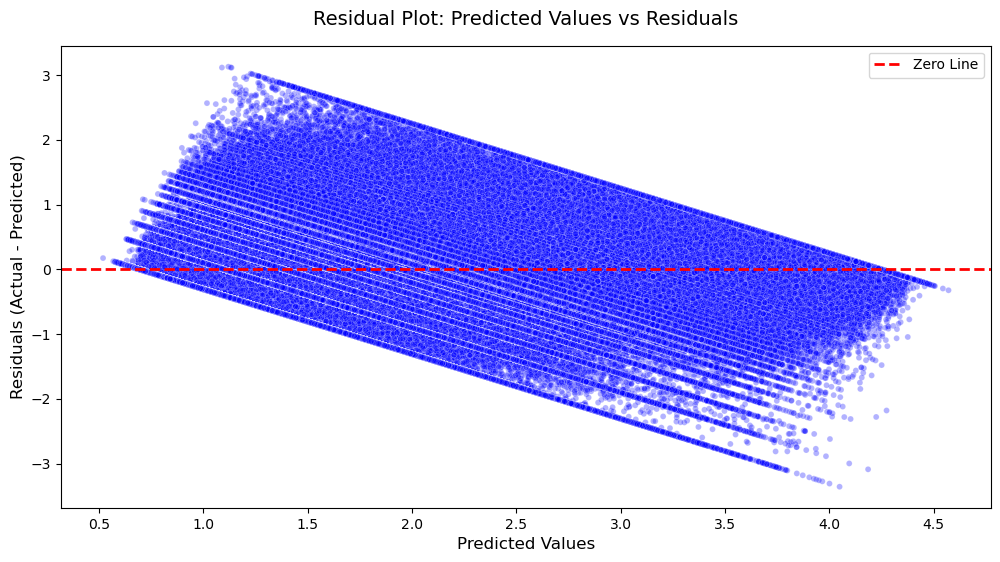

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, color='blue', alpha=0.3, size=2, legend=False)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Line')
plt.title('Residual Plot: Predicted Values vs Residuals', fontsize=14, pad=15)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.legend()
plt.show()

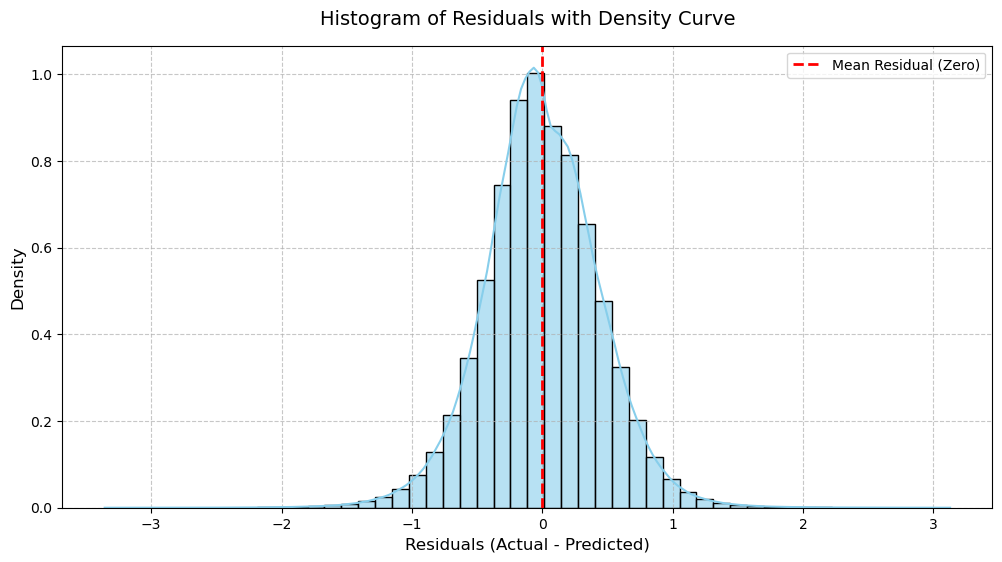

In [108]:
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=50, kde=True, color='skyblue', stat='density', alpha=0.6)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Mean Residual (Zero)')
plt.title('Histogram of Residuals with Density Curve', fontsize=14, pad=15)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

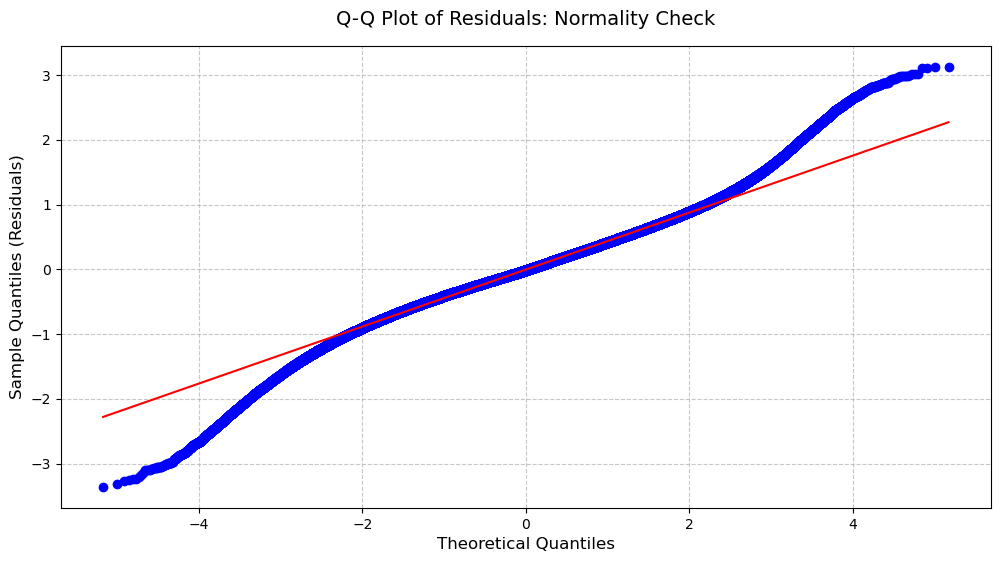

In [25]:
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt, rvalue=False)
plt.title("Q-Q Plot of Residuals: Normality Check", fontsize=14, pad=15)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles (Residuals)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Test Prediction
test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'id': test_index,
    'unit_sales': test_pred
})

submission.shape
# Output: (3370464, 2)

## Trying different Features

In [55]:
#train['lag_1'] = train.groupby('item_nbr')['unit_sales'].shift(1)
#train['lag_14'] = train.groupby('item_nbr')['unit_sales'].shift(14)

# Rolling stats
#train['rolling_std_7'] = train.groupby('item_nbr')['unit_sales'].shift(1).rolling(7).std().reset_index(0, drop=True)

# Trend
#train['weekly_trend'] = (train['lag_7'] - train['lag_14']) / (train['lag_14'] + 1e-5)

# Target encoding
#train['item_mean_sales'] = train.groupby('item_nbr')['unit_sales'].transform('mean')

#train['store_mean_sales'] = train.groupby('store_nbr')['unit_sales'].transform('mean')

In [67]:
#new_features = ['store_mean_sales','item_mean_sales','onpromotion','perishable','lag_1','lag_7','lag_14','rolling_mean_7','rolling_mean_30','rolling_std_7',
 #               'weekly_trend','transactions','dayofweek','is_weekend','weekofyear','month','quarter','type',
 #               'cluster','dcoilwtico','family','is_holiday']
#X_train = train[new_features]
#y_train = train['unit_sales']

In [71]:
#tscv = TimeSeriesSplit(n_splits=3)
#rmse_scores = []
#r2_scores = []

#params = {
   # 'objective': 'regression',
   # 'metric': 'rmse',
   # 'verbosity': -1,
   # 'boosting_type': 'gbdt',
   # 'learning_rate': 0.07508884729488528,
   # 'num_leaves': 49,
   # 'max_depth': 12,  
   # 'subsample': 0.9464704583099741,
   # 'bagging_fraction': 0.9464704583099741,
   # 'bagging_freq': 4,
   # 'feature_fraction': 0.6571467271687763,
   # 'min_data_in_leaf': 5, 
   # 'min_split_gain': 0.1, 
   # 'device': 'cpu',
   # 'max_bin': 255,
   # 'min_data_in_bin': 3,
   # 'force_col_wise': True
#}

#for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
 #   X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
 #   y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] 
    
  #  model = LGBMRegressor(**params, n_estimators=443, random_state=42, n_jobs=-1)
    
  #  model.fit(
   #     X_tr, 
   #     y_tr,
   #     eval_set=[(X_val, y_val)],
   #     eval_metric='rmse',
   #     callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
   # )
    
    #y_pred = model.predict(X_val)
    
    #rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
    #r2 = r2_score(np.expm1(y_val), np.expm1(y_pred))
    
    #rmse_scores.append(rmse)
    #r2_scores.append(r2)
    
    #print(f"Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}\n")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 0.446341
Fold 1 - RMSE: 5.3226, R²: 0.7615

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[429]	valid_0's rmse: 0.442515
Fold 2 - RMSE: 5.1048, R²: 0.7803

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[425]	valid_0's rmse: 0.440384
Fold 3 - RMSE: 4.9723, R²: 0.7818



In [73]:
#print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
#print(f"Average R² Score: {np.mean(r2_scores):.4f}")

#Average RMSE: 5.1332
#Average R² Score: 0.7745

Average RMSE: 5.1332
Average R² Score: 0.7745


## NWRMSLE Comparison

In [93]:
# NWRMSLE = 0.504 ~ 0.519 at Corporación Favorita Grocery Sales Forecasting competition
# our Average NWRMSLE: 0.4423

In [79]:
#def nwrmsle(y_true, y_pred, weights):
    """
    Normalized Weighted Root Mean Squared Logarithmic Error.
    """
 #   log_diff = np.log1p(y_pred) - np.log1p(y_true)
 #   squared_log_diff = log_diff ** 2
 #   weighted_squared_log_diff = weights * squared_log_diff
 #   return np.sqrt(np.sum(weighted_squared_log_diff) / np.sum(weights))

In [81]:
#tscv = TimeSeriesSplit(n_splits=3)
#weight = train['perishable'] * 0.25 + 1
#nwrmsle_scores = []
#rmse_scores = []
#r2_scores = []

#params = {
 #   'objective': 'regression',
 #   'metric': 'rmse',
 #   'verbosity': -1,
 #   'boosting_type': 'gbdt',
 #   'learning_rate': 0.07508884729488528,
 #   'num_leaves': 49,
 #   'max_depth': 12,  
 #   'subsample': 0.9464704583099741,
 #   'bagging_fraction': 0.9464704583099741,
 #   'bagging_freq': 4,
 #   'feature_fraction': 0.6571467271687763,
 #   'min_data_in_leaf': 5, 
 #   'min_split_gain': 0.1, 
 #   'device': 'cpu',
 #   'max_bin': 255,
 #   'min_data_in_bin': 3,
 #   'force_col_wise': True
#}

#for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
 #   X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
 #   y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] 
 #   w_tr = weight.iloc[train_idx]
 #   w_val = weight.iloc[val_idx]
    
 #   model = LGBMRegressor(**params, n_estimators=443, random_state=42, n_jobs=-1)

 #   model.fit(
  #      X_tr, 
  #      y_tr,
  #      sample_weight=w_tr,
  #      eval_set=[(X_val, y_val)],
  #      eval_metric='rmse',
  #      callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
  #  )
    
   # y_pred = model.predict(X_val)

   # nwrmsle_score = nwrmsle(np.expm1(y_val), np.expm1(y_pred), w_val)
   # rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
   # r2 = r2_score(np.expm1(y_val), np.expm1(y_pred))
    
   # nwrmsle_scores.append(nwrmsle_score)
   # rmse_scores.append(rmse)
   # r2_scores.append(r2)
    
   # print(f"Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}\n")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 0.445933
Fold 1 - RMSE: 5.3147, R²: 0.7622

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[367]	valid_0's rmse: 0.442462
Fold 2 - RMSE: 5.1099, R²: 0.7799

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[443]	valid_0's rmse: 0.439921
Fold 3 - RMSE: 4.9709, R²: 0.7819



In [83]:
#print(f"Average NWRMSLE: {np.mean(nwrmsle_scores):.4f}")
#print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
#print(f"Average R² Score: {np.mean(r2_scores):.4f}")

#Average NWRMSLE: 0.4423
#Average RMSE: 5.1318
#Average R² Score: 0.7747

Average NWRMSLE: 0.4423
Average RMSE: 5.1318
Average R² Score: 0.7747
